[pdf链接](https://arxiv.org/abs/1706.03762)

[源码链接-Tensorflow](https://github.com/tensorflow/tensor2tensor)  [源码链接-pytorch](https://blog.csdn.net/stupid_3/article/details/83184691)

解读

1.采用encoder-decoder结构，其中encoder将输入序列 [x1,x2...xn] 映射到向量表示 [z1,z2...zn] ,然后decoder生成一个输出序列 [y1,y2...ym] ,m和n不一定等长，每个时刻输出一个结果。

2.transformer模型完全基于attention机制，抛弃了传统的RNN和CNN，通过attention函数对Query和一组Key-Value映射到输出，计算相关度，
实现并行处理数据

## 摘要与网络结构框图

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 Englishto-German translation task, improving over the existing best results, including
ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.8 after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the Transformer generalizes well to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.
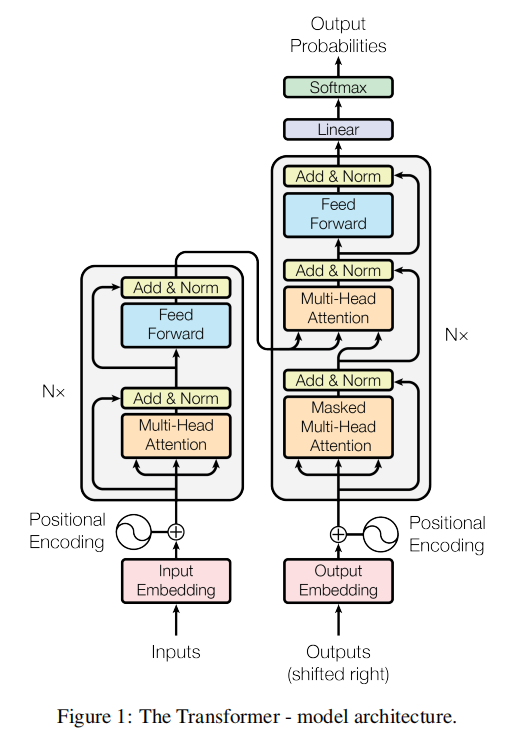

## 主要创新点
使用Attention代替RNN,CNN，实现并行处理数据，提高效率

Scaled Dot-Product Attention：点积注意力机制是归一化的点乘Attention，假设输入的query q、key维度为 dk ,value维度为 dv , 那么就计算query和每个key的点乘操作，并除以根号dk，然后应用Softmax函数计算权重。
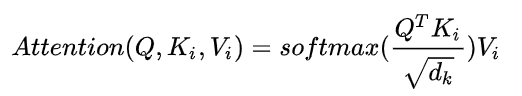

Multi-Head Attention：

1.首先对Q、K、V做一次线性映射，将输入维度均为 dmodel 的 Q、K、V 矩阵映射到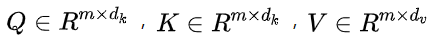

2.然后在采用Scaled Dot-Product Attention计算出结果

3.多次进行上述两步操作，然后将得到的结果进行合并

4.将合并的结果进行线性变换

## 步骤和过程
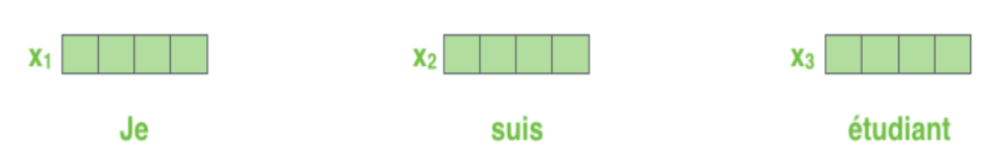
以词嵌入为例，将每个单词编码为一个512维度的向量，用上面这张简短的图形来表示这些向量。词嵌入的过程只发生在最底层的Encoder。但是对于所有的Encoder来说，都可以按下图来理解。输入（一个向量的列表，每个向量的维度为512维，在最底层Encoder作用是词嵌入，其他层就是其前一层的output）。另外这个列表的大小和词向量维度的大小都是可以设置的超参数。一般情况下，它是我们训练数据集中最长的句子的长度。
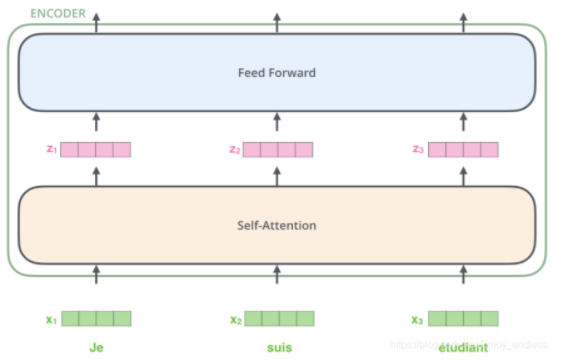
在每个单词进入Self-Attention层后都会有一个对应的输出。Self-Attention层中的输入和输出是存在依赖关系的，而前馈层则没有依赖，所以在前馈层，我们可以用到并行化来提升速率。
Transformer中的每个Encoder接收一个512维度的向量的列表作为输入，然后将这些向量传递到‘self-attention’层，self-attention层产生一个等量512维向量列表，然后进入前馈神经网络，前馈神经网络的输出也为一个512维度的列表，然后将输出向上传递到下一个encoder。

self attention计算：
1、计算self attention的第一步是从每个Encoder的输入向量上创建3个向量（在这个情况下，对每个单词做词嵌入）。所以，对于每个单词，创建一个Query向量，一个Key向量和一个Value向量。这些向量是通过词嵌入乘以训练过程中创建的3个训练矩阵而产生的。

2、计算self attention的第二步是计算得分。假设我们在计算第一个单词“thinking”的self attention。我们需要根据这个单词对输入句子的每个单词进行评分。当我们在某个位置编码单词时，分数决定了对输入句子的其他单词的关照程度。
通过将query向量和key向量做点积来对相应的单词打分。所以，如果我们处理开始位置的的self attention，则第一个分数为q1和k1的点积，第二个分数为q2和k2的点积。

3、第三步和第四步的计算，是将第二部的得分除以8*sqrt{dk}，（论文中使用key向量的维度是64维，其平方根=8，这样可以使得训练过程中具有更稳定的梯度。这个sqrt{dk}并不是唯一值，经验所得）。然后再将得到的输出通过softmax函数标准化，使得最后的列表和为1。这个softmax的分数决定了当前单词在每个句子中每个单词位置的表示程度。

4、第五步是将每个Value向量乘以softmax后的得分。这里实际上的意义在于保存对当前词的关注度不变的情况下，降低对不相关词的关注。

5、第六步是累加加权值的向量。 这会在此位置产生self-attention层的输出（对于第一个单词）。

添加位置编码：

对于输入序列中单词顺序的考虑还是很有必要的，于是我们可以引入位置编码向量；
为了解决这个问题，变换器为每个输入嵌入添加了一个向量。这些位置编码向量有固定的生成方式，所以获取他们是很方便的，但是这些信息确是很有用的，他们能捕捉大量每个单词的位置，或者序列中不同单词之间的距离。将这些信息也添加到词嵌入中，然后与Q/K/V向量点击，获得的attention就有了距离的信息了。

Decoder：
当序列输入时，Encoder开始工作，最后在其顶层的Encoder输出矢量组成的列表，然后我们将其转化为一组attention的集合（K,V）。（K,V）将带入每个Decoder的“encoder-decoder attention”层中去计算（这样有助于decoder捕获输入序列的位置信息）

最后的Linear和softmax层：
Decoder的输出是浮点数的向量列表。我们是如何将其变成一个单词的呢？这就是最终的线性层和softmax层所做的工作。

线性层是一个简单的全连接神经网络，它是由Decoder堆栈产生的向量投影到一个更大的向量中，称为对数向量；

假设实验中我们的模型从训练数据集上总共学习到1万个英语单词（“Output Vocabulary”）。这对应的Logits矢量也有1万个长度-每一段表示了一个唯一单词的得分。在线性层之后是一个softmax层，softmax将这些分数转换为概率。选取概率最高的索引，然后通过这个索引找到对应的单词作为输出。

## 结果分析
Transformer 与 RNN 不同，可以比较好地并行训练。

Transformer 本身是不能利用单词的顺序信息的，因此需要在输入中添加位置 Embedding，否则 Transformer 就是一个词袋模型了。

Transformer 的重点是 Self-Attention 结构，其中用到的 Q, K, V 矩阵通过输入进行线性变换得到。

Transformer 中 Multi-Head Attention 中有多个 Self-Attention，可以捕获单词之间多种维度上的相关系数 attention score。

## 启示
1.Transformer的设计最大的带来性能提升的关键是将任意两个单词的距离是1，这对解决NLP中棘手的长期依赖问题是非常有效的。

2.Transformer不仅仅可以应用在NLP的机器翻译领域，甚至可以不局限于NLP领域，是非常有科研潜力的一个方向。

3.算法的并行性非常好，符合目前的硬件（主要指GPU）环境。